Importing The Required Libraries !

In [11]:
import numpy as np 
import matplotlib.pyplot as plt
from ISLP.models import summarize
from pygam import GAM ,s as s_gam, LinearGAM
from ISLP.pygam import approx_lam,degrees_of_freedom

Defining the True Function $f(X)$ and other useful functions

In [12]:
def generate_X(N_obs=100,use_fixed_X=True,random_seed=0,N_samples_in_obs=100):
    '''
    In our assumption, the X is the same for all the QQQ iterations. We can also generate X randomly for each iteration. (so in other words it depends on what we are taking the randomness on X and Y or Y(i.e. epsilon alone) only)
    if we want to take the randomness on X, we can set use_fixed_X to False. ( in our case by default it is True, so we are taking the randomness on Y only)

    N_obs: Length of X_train_all ( how many X_train we have)
    use_fixed_X: if True, we generate the same X for all the N_obs iterations
    random_seed: random seed for generating the uniform distribution
    N_samples_in_obs: number of samples in each X_train (i.e. the 100 given in the problem)
    '''
    np.random.seed(random_seed)
    if use_fixed_X:
        X_fixed = np.random.uniform(0,1,N_samples_in_obs)
        X_train_ALL  = [ X_fixed for _ in range(N_obs)]
        X_train_ALL = np.array(X_train_ALL)
    else:
        X_train_ALL = np.random.uniform(0, 1, (N_samples_in_obs, N_obs))
    X_train_ALL = np.sort(X_train_ALL, axis=1)
    return X_train_ALL

def f(X):
    return np.sin(12*(X+0.2))/(X+0.2)

def VAR_pointwise(x_0,X_train_i,first_term):
    '''
    x_0: the new point 
    X_train_i: the training points that we have used to generate the bases N_old
    returns the Variance of f_hat_lambda at x_0 (i.e. pointwise)
    '''
    x_0 = np.array([[x_0]])
    N_new = first_term.build_columns(x_0).todense()
    N_old = first_term.build_columns(X_train_i).todense()
    P = first_term.build_penalties().todense() # lambda * Omega_k 
    mid = np.linalg.inv(N_old.T*N_old+P)
    VAR = N_new*mid*N_old.T*N_old*mid*N_new.T # formula as discussed in the report 
    return VAR

def expectation_pointwise(x_0,X_train_i,first_term,Expected_of_y_train):
    '''
    x_0:the new point 
    X_train_i: the training points that we have used to generate the bases N_old
    Expected_of_y_train: this is what we have discussed in the report E(y_train) = f(x_train) 
    returns: the expectation of f_hat_lambda at x_0 (i.e. pointwise)
    '''
    x_0 = np.array([[x_0]])
    N_new = first_term.build_columns(x_0).todense()
    N_old = first_term.build_columns(X_train_i).todense()
    P = first_term.build_penalties().todense()
    mid = np.linalg.inv(N_old.T*N_old+P)
    EXPECTATION = N_new*mid*N_old.T*Expected_of_y_train  # formula as discussed in the report
    return EXPECTATION

def MSE_pointwise(x_0,X_train_i,first_term,Expected_of_y_train):
    '''
    x_0:the new point 
    X_train_i: the training points that we have used to generate the bases N_old
    Expected_of_y_train: this is what we have discussed in the report E(y_train) = f(x_train) 
    returns: the MSE of f_hat_lambda at x_0 (i.e. pointwise)
    '''
    bias_i = bias_pointwise(x_0,X_train_i,first_term,Expected_of_y_train)
    variance_y_train_i = VAR_pointwise(x_0,X_train_i,first_term)
    
    MSE_i = (bias_i)**2 + variance_y_train_i 
    return MSE_i

def bias_pointwise(x_0,X_train_i,first_term,Expected_of_y_train):
    '''
    x_0:the new point 
    X_train_i: the training points that we have used to generate the bases N_old
    Expected_of_y_train: this is what we have discussed in the report E(y_train) = f(x_train) 
    returns: the bias of f_hat_lambda at x_0 (i.e. pointwise)
    '''
    expectation_y_train_i = expectation_pointwise(x_0,X_train_i,first_term,Expected_of_y_train)
    f_true_x_0 = f(x_0) # notice that here also we could have gotten it from doing E(y) @ x_0, same thing
    bias = f_true_x_0 - expectation_y_train_i
    return bias
def bias_pointwise_other_way(x_0,X_train_i,first_term,Expected_of_y_train):
    '''
    x_0:the new point 
    X_train_i: the training points that we have used to generate the bases N_old
    Expected_of_y_train: this is what we have discussed in the report E(y_train) = f(x_train) 
    returns: the bias of f_hat_lambda at x_0 (i.e. pointwise)
    '''
    expectation_y_train_i = expectation_pointwise(x_0,X_train_i,first_term,Expected_of_y_train) # here we are passing Expected_of_y_train as a whole not just the value of x_0 since this is the formula discussed in the report 
    #finding the index of x_0 in X_train_i
    index = np.where(X_train_i == x_0)
    Expected_of_y_train_0 = Expected_of_y_train[index] # this is the expectation of the first point in the training set
    bias = Expected_of_y_train_0 - expectation_y_train_i
    return bias

Generating X and Y Train and Test ! Getting our $x_0$ points which we will evaluate our study on

In [13]:
#Note that when we say test we mean the one we will be calculating std error, variance, mean etc. On (i.e. our x_0)
# x_0 could be equal to some training points or could be different. Since now we are able to calculate the variance, std error, bias,... of the prediction at any point, we can calculate them as a special case on the training points as well.
np.random.seed(0)
N_obs = 100
N_samples_in_obs = 100 # the N given in the exercise 
'''Training DATA'''

X_train_ALL = generate_X(N_obs=N_obs,use_fixed_X=True,random_seed=0,N_samples_in_obs=N_samples_in_obs)
X_train_ALL = np.array([X_train.reshape(-1,1) for X_train in X_train_ALL])
F_of_X_train = np.array([f(X) for X in X_train_ALL])
EPSILON_train_ALL = np.random.normal(0, 1, (N_obs, N_samples_in_obs))
EPSILON_train_ALL = np.array([EPSILON_train.reshape(-1,1) for EPSILON_train in EPSILON_train_ALL])
Y_train_ALL = F_of_X_train + EPSILON_train_ALL
Expected_y_train = np.mean(Y_train_ALL,axis=0).reshape(-1,1) # this we will use whenever we refer to E(y_train) or f(x_train) ( we need it in order to calculate any pointwise quantity) [[[NOTICE THAT instead of this we could have used F_of_X_train] since theoritically with a large N they should be the same(see report!)]]
'''TEST DATA'''
X_test_ALL = generate_X(N_obs=N_obs,use_fixed_X=True,random_seed=0,N_samples_in_obs=N_samples_in_obs)
X_test_ALL = np.array([X_test.reshape(-1,1) for X_test in X_test_ALL])
EPSILON_test_ALL = np.random.normal(0, 1, (N_obs, N_samples_in_obs))
EPSILON_test_ALL = np.array([EPSILON_test.reshape(-1,1) for EPSILON_test in EPSILON_test_ALL])
F_of_X_test = np.array([f(X) for X in X_test_ALL])
Y_test_ALL = F_of_X_test + EPSILON_test_ALL

# $CV(\lambda)$ and $EPE(\lambda)$

In [14]:
i = 0 
df = 5
CV = []
EPE = []
MSE_all = []
X_axis = np.arange(5,15,0.5)
BIAS_ALL = []
for df in X_axis:
    X_train_i = X_train_ALL[i]
    y_train_i = Y_train_ALL[i]
    F_of_x_train_i = F_of_X_train[i]
    gam  = LinearGAM(s_gam(0, lam=0.6,n_splines=20,penalties='auto'))
    gam.fit(X_train_i, y_train_i)
    first_term = gam.terms[0]
    lam_ = approx_lam(X_train_i, first_term, df)
    first_term.lam = lam_
    gam.fit(X_train_i, y_train_i) 
    CV.append(gam.statistics_['GCV'])
    
    VAR = []
    STD = []
    BIAS = []
    EXP = []
    for x_0 in X_train_i:
        var_x_0 = VAR_pointwise(x_0,X_train_i,first_term)
        VAR.append(var_x_0)
        STD.append(np.sqrt(var_x_0))
        bias = bias_pointwise(x_0,X_train_i,first_term,Expected_y_train)
        BIAS.append(bias)
        exp_x_0 = expectation_pointwise(x_0,X_train_i,first_term,Expected_y_train)
        EXP.append(exp_x_0)
    BIAS = np.array(BIAS)
    VAR = np.array(VAR)
    STD = np.array(STD)
    EXP = np.array(EXP)
    BIAS_ALL.append(np.mean(BIAS))
    MSE = BIAS**2 + VAR
    EPE.append(MSE.mean()+1)
    MSE_all.append(MSE.mean())
    f_hat = gam.predict(X_train_i)
EPE = np.array(EPE)
MSE = np.array(MSE)

## Reproducing Figure 5.9 

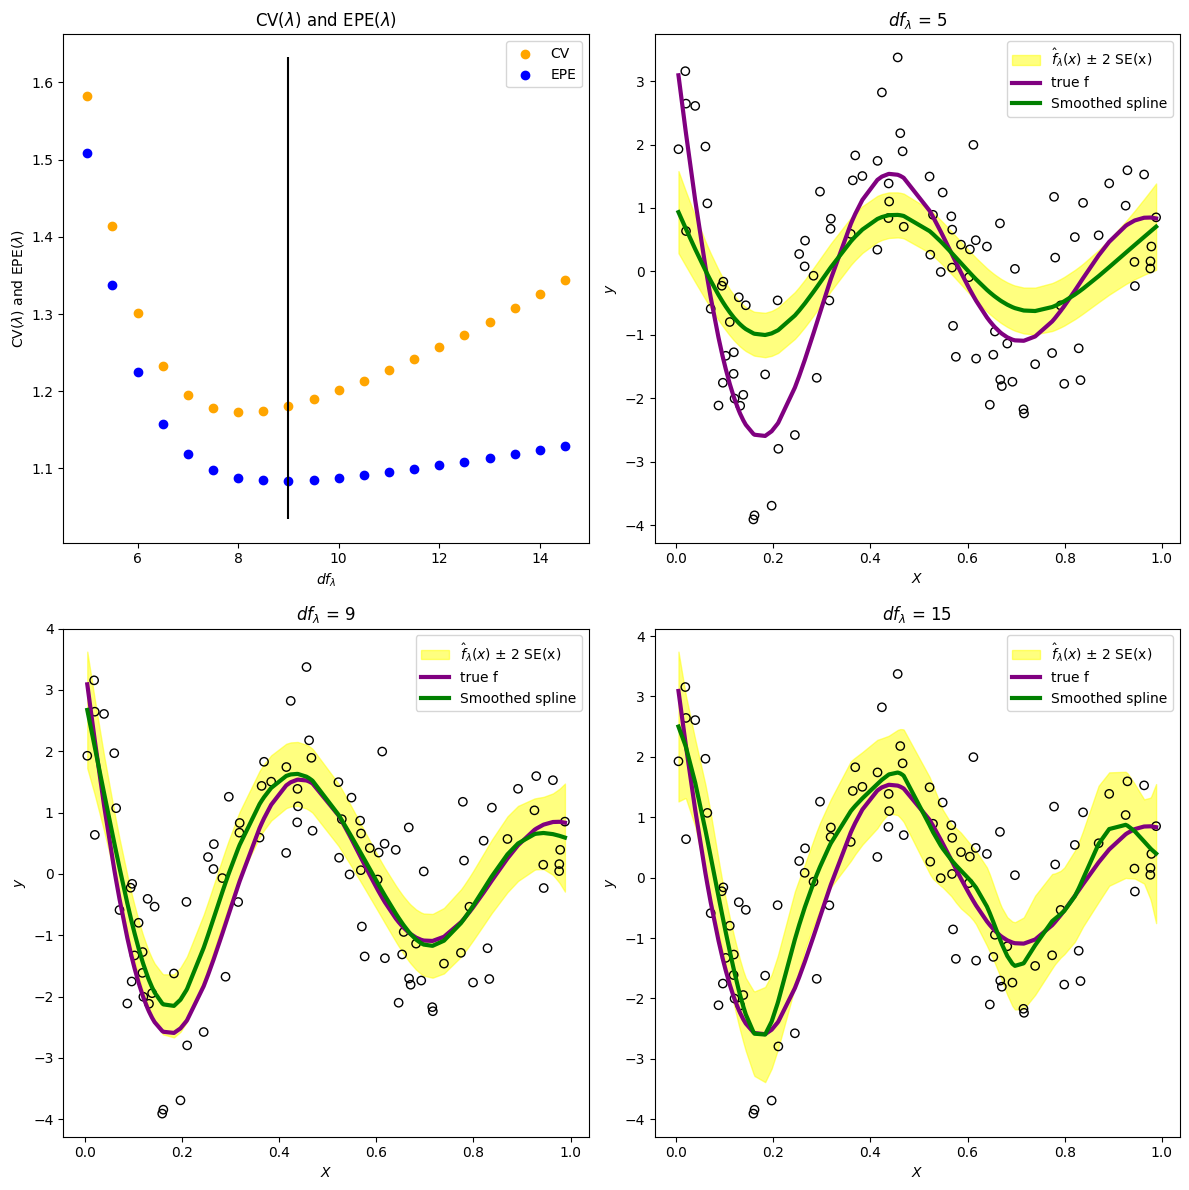

In [24]:
i = 0 
df = 5
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.flatten()  
plot_positions = {5: 1, 9: 2, 15: 3}
for df in [5,9,15]:
    X_train_i = X_train_ALL[i] 
    y_train_i = Y_train_ALL[i]
    F_of_x_train_i = F_of_X_train[i]
    gam  = LinearGAM(s_gam(0, lam=0.6,n_splines=20,penalties='auto'))
    gam.fit(X_train_i, y_train_i) 
    first_term = gam.terms[0]
    lam_ = approx_lam(X_train_i, first_term, df)
    first_term.lam = lam_
    gam.fit(X_train_i, y_train_i) 

    VAR = []
    STD = []
    BIAS = []
    EXP = []
    for x_0 in X_train_i:
        var_x_0 = VAR_pointwise(x_0,X_train_i,first_term)
        VAR.append(var_x_0)
        STD.append(np.sqrt(var_x_0))
        bias = bias_pointwise(x_0,X_train_i,first_term,Expected_y_train)
        BIAS.append(bias)
        exp_x_0 = expectation_pointwise(x_0,X_train_i,first_term,Expected_y_train)
        EXP.append(exp_x_0)
    BIAS = np.array(BIAS)
    VAR = np.array(VAR)
    STD = np.array(STD)
    EXP = np.array(EXP)
    MSE = BIAS**2 + VAR
    f_hat = gam.predict(X_train_i)

    '''Plotting the results like the book'''
    ax = axs[plot_positions[df]]
    ax.fill_between(X_train_i.squeeze(), f_hat - 2*STD.squeeze().squeeze(), f_hat + 2*STD.squeeze().squeeze(), color='yellow', alpha=0.5, label='$\hat{f}_\lambda(x)$ ± 2 SE(x)')
    ax.scatter(X_train_i.squeeze(), y_train_i, facecolors='none', edgecolors='black', marker='o')
    ax.plot(X_train_i.squeeze(), F_of_x_train_i, color='purple', linewidth=3, label='true f')
    ax.plot(X_train_i.squeeze(), f_hat, color='green', linewidth=3, label='Smoothed spline')
    ax.set_xlabel("$X$")
    ax.set_ylabel("$y$")
    ax.set_title(f"$df_\lambda$ = {df}")
    ax.legend()
axs[0].scatter(X_axis,CV,color='orange',label='CV')
axs[0].scatter(X_axis,EPE,color='blue',label='EPE')
axs[0].vlines(x=X_axis[np.argmin(EPE)],ymin=min(EPE)-0.05,ymax=max(CV)+0.05,color='black',linestyles='-')
axs[0].set_xlabel('$df_\lambda$')
axs[0].set_ylabel('CV$(\lambda$) and EPE$(\lambda)$')
axs[0].legend()
axs[0].set_title('CV$(\lambda$) and EPE$(\lambda)$')

plt.tight_layout()
plt.show()


# Further Analysis on $df_\lambda=5,9,15$ !

the MSE of the model with df = 5 is =  0.507938899899476
the MSE of the model with df = 9 is =  0.08395706374576857
the MSE of the model with df = 15 is =  0.13493623145207426


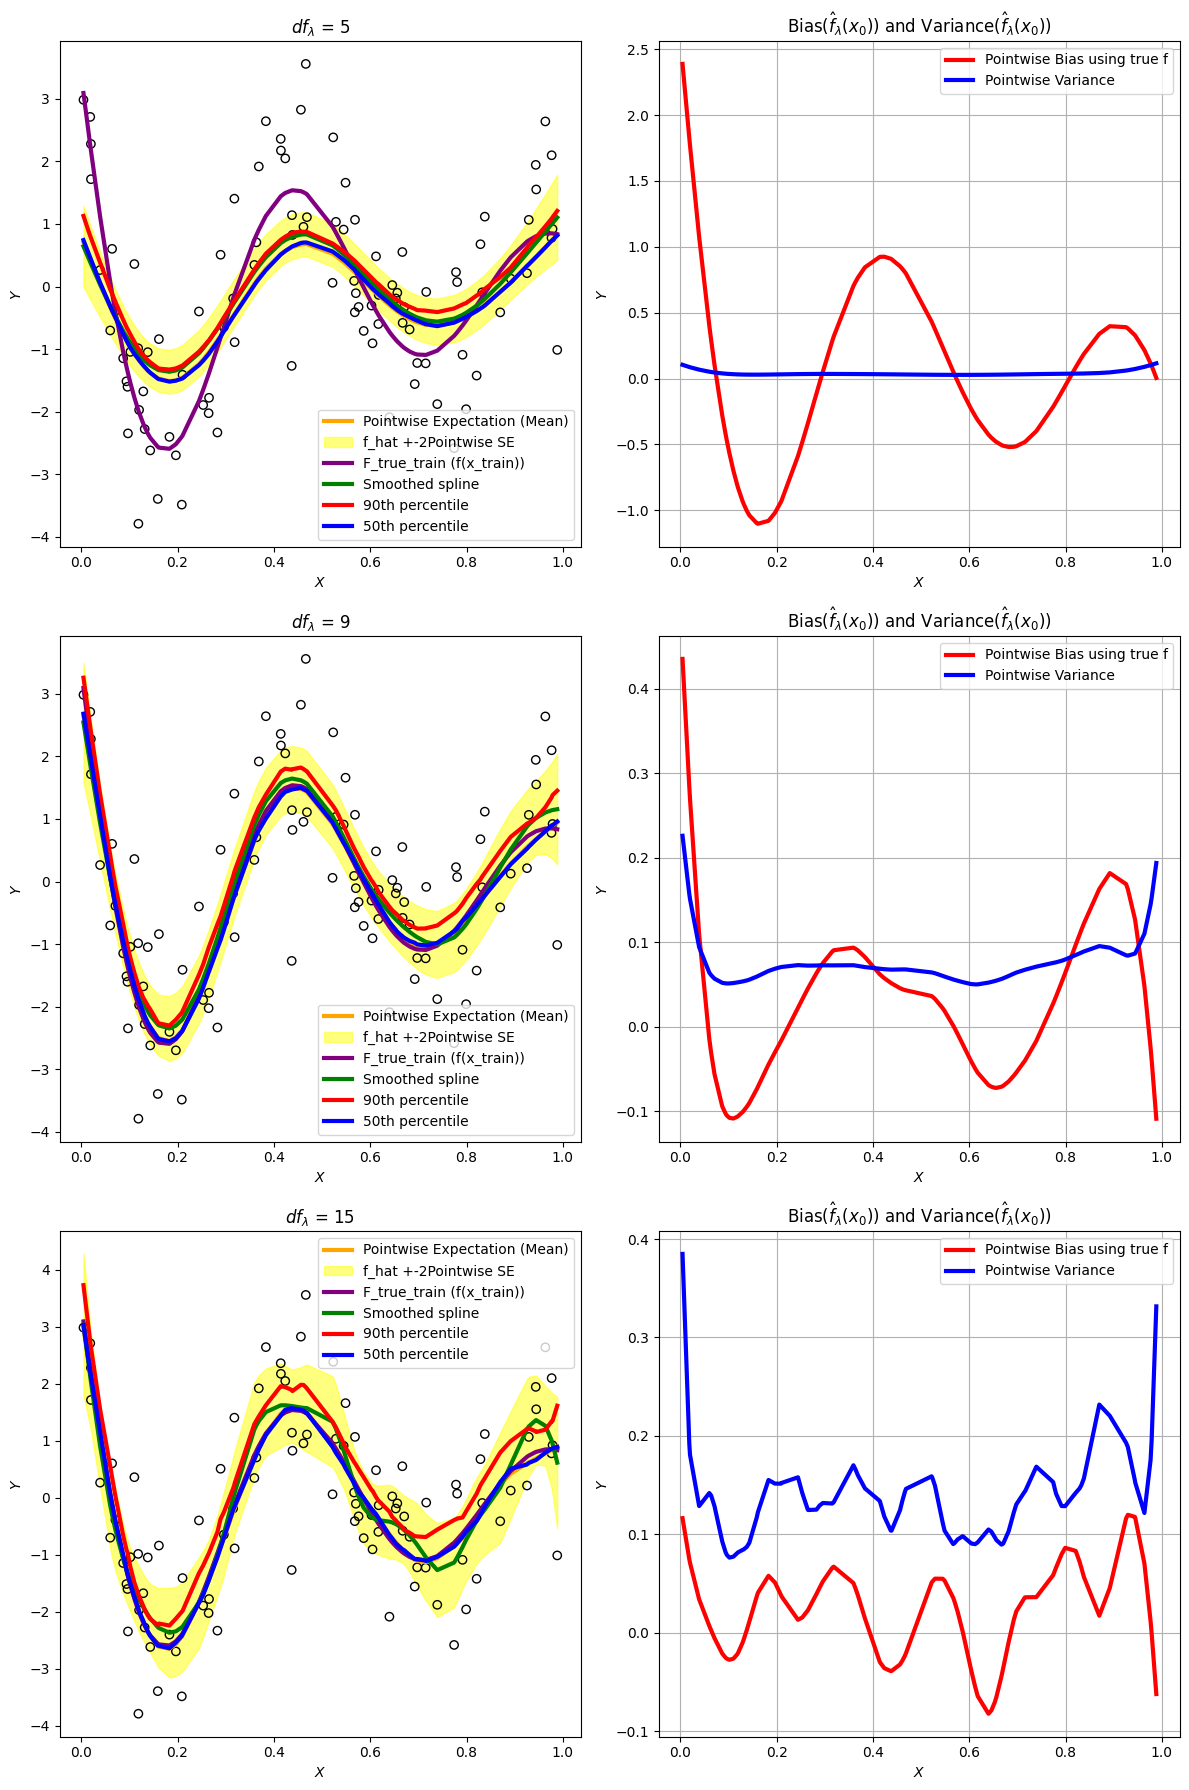

In [17]:
dfs = [5, 9, 15]
fig, axs = plt.subplots(len(dfs), 2, figsize=(12, 6 * len(dfs)))  
BIAS_1_ALL = []
BIAS_2_ALL = []
for i, df in enumerate(dfs):
    X_train_i = X_train_ALL[i] # we chose the 0 we could have chosen any one
    y_train_i = Y_train_ALL[i]
    F_of_x_train_i = F_of_X_train[i]
    '''Note that if you want to fit a smoothing spline in python you need to choose Splineterm with penalties = 'auto' and then fit the model with the lambda you want. In there case they are using the number of bases (i.e. # of splines = 20, but as mentionned in the book, this is a method to compute smoothing splines more efficiently)'''
    gam  = LinearGAM(s_gam(0, lam=0.6,n_splines=20,penalties='auto')) # 0.6 value doesn't matter since we will change it before fitting it
    gam.fit(X_train_i, y_train_i) # won't use this fitted model, we will change lambda and then use it 
    first_term = gam.terms[0]
    lam_ = approx_lam(X_train_i, first_term, df)
    first_term.lam = lam_
    gam.fit(X_train_i, y_train_i) #refitting the model with this lambda (i.e. df = 5)

    '''
    Getting the variances and the std errors of the model pointwise as discussed in the report
    '''
    VAR = []
    STD = []
    BIAS = []
    EXP = []
    BIAS_2 = []
    PER_90 = []
    PER_50 = []
    for x_0 in X_train_i:
        f_lambda_hat_x_0 = [] 
        for y_train_i in Y_train_ALL:
            gam.fit(X_train_i, y_train_i) #refitting the model with this new y_train_i
            f_lambda_hat_x_0.append(gam.predict(x_0))
        f_lambda_hat_x_0 = np.array(f_lambda_hat_x_0)
        PER_90.append(np.percentile(f_lambda_hat_x_0,90))
        PER_50.append(np.percentile(f_lambda_hat_x_0,50))
        var_x_0 = VAR_pointwise(x_0,X_train_i,first_term)
        VAR.append(var_x_0)
        STD.append(np.sqrt(var_x_0))
        bias = bias_pointwise(x_0,X_train_i,first_term,Expected_y_train)
        BIAS.append(bias)
        bias_2 = bias_pointwise_other_way(x_0,X_train_i,first_term,Expected_y_train) # this is just to compare them later on the bias with each other (as it will be discussed in the report as well! )
        BIAS_2.append(bias_2)
        exp_x_0 = expectation_pointwise(x_0,X_train_i,first_term,Expected_y_train)
        EXP.append(exp_x_0)
    
    BIAS = np.array(BIAS)
    VAR = np.array(VAR)
    STD = np.array(STD)
    EXP = np.array(EXP)
    BIAS2 = np.array(BIAS_2)
    MSE = BIAS**2 + VAR
    BIAS_1_ALL.append(BIAS)
    BIAS_2_ALL.append(BIAS_2) # this is just to compare them later on the bias with each other (as it will be discussed in the report as well! )
    print(f"the MSE of the model with df = {df} is =  {MSE.mean()}") # this is the MSE of the model (i.e. the one we have fitted with df = 5
    f_hat = gam.predict(X_train_i)
    ax1 = axs[i, 0]
    ax1.plot(X_train_i.squeeze(), EXP.squeeze(), color='orange', linewidth=3, label='Pointwise Expectation (Mean)')
    ax1.fill_between(X_train_i.squeeze(), f_hat - 2*STD.squeeze(), f_hat + 2*STD.squeeze(), color='yellow', alpha=0.5, label='f_hat +-2Pointwise SE')
    ax1.scatter(X_train_i.squeeze(), y_train_i, facecolors='none', edgecolors='black', marker='o')
    ax1.plot(X_train_i.squeeze(), F_of_x_train_i, color='purple', linewidth=3, label='F_true_train (f(x_train))')
    ax1.plot(X_train_i.squeeze(), f_hat, color='green', linewidth=3, label='Smoothed spline')
    ax1.plot(X_train_i.squeeze(), PER_90, color='red', linewidth=3, label='90th percentile')
    ax1.plot(X_train_i.squeeze(), PER_50, color='blue', linewidth=3, label='50th percentile')
    ax1.legend()
    ax1.set_title(f'$df_\lambda$ = {df}')
    ax1.set_xlabel('$X$')
    ax1.set_ylabel('$Y$')

    ax2 = axs[i, 1]
    ax2.plot(X_train_i.squeeze(), BIAS.squeeze(), color='red', linewidth=3, label='Pointwise Bias using true f')
    ax2.plot(X_train_i.squeeze(), VAR.squeeze(), color='blue', linewidth=3, label='Pointwise Variance')
    ax2.legend()
    ax2.grid(True)
    ax2.set_title('Bias($\hat{f}_\lambda(x_0)$) and Variance($\hat{f}_\lambda(x_0)$)')
    ax2.set_xlabel('$X$')
    ax2.set_ylabel('$Y$')

plt.tight_layout()
plt.show()

## Comparison of the two ways of getting the Bias ! ( Showcasing that indeed they are the same)

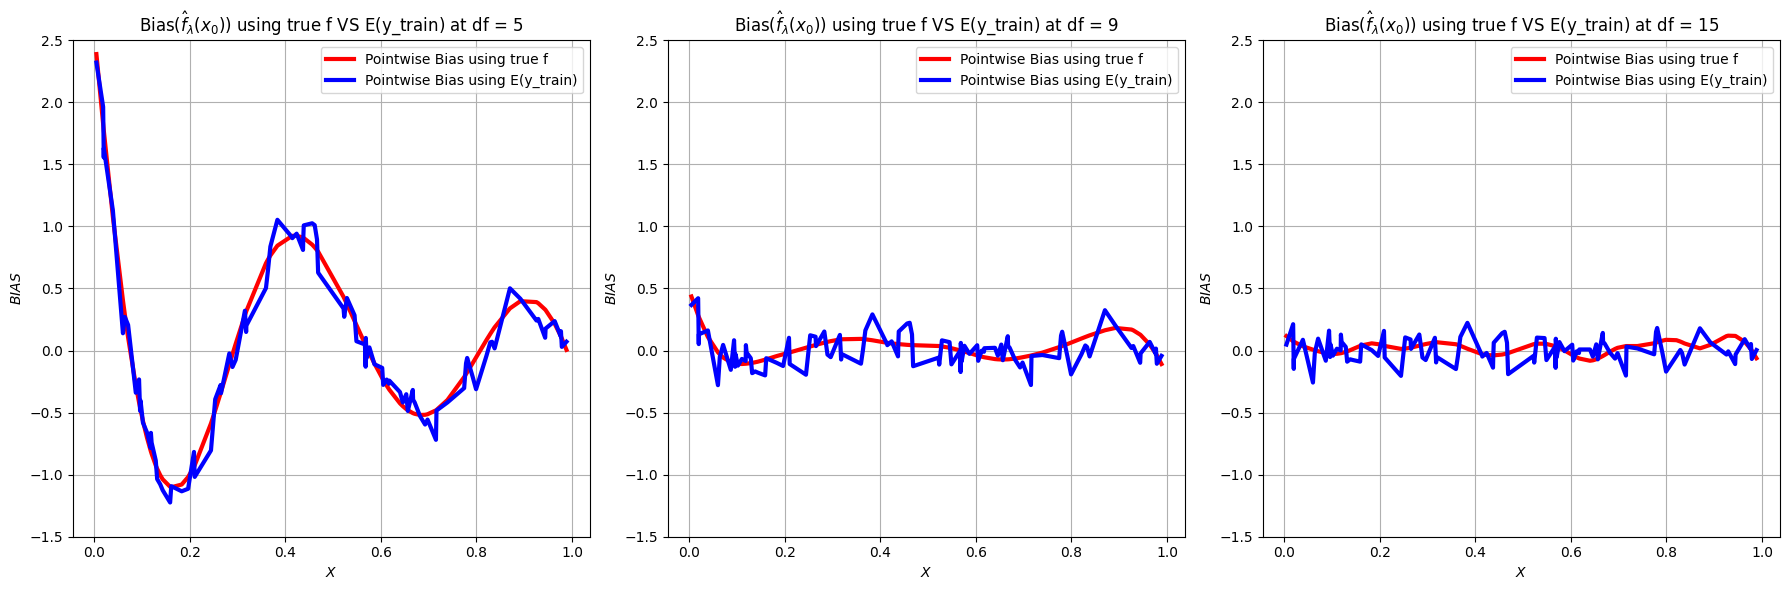

In [18]:
b1_0 = np.array(BIAS_1_ALL[0]).squeeze().squeeze()
b1_1 = np.array(BIAS_1_ALL[1]).squeeze().squeeze()
b1_2 = np.array(BIAS_1_ALL[2]).squeeze().squeeze()

b2_0 = np.array(BIAS_2_ALL[0]).squeeze().squeeze()
b2_1 = np.array(BIAS_2_ALL[1]).squeeze().squeeze()
b2_2 = np.array(BIAS_2_ALL[2]).squeeze().squeeze()
plt.figure(figsize=(18, 6))  

# First subplot for df = 5
plt.subplot(1, 3, 1)  
plt.plot(X_train_i.squeeze(), b1_0, color='red', linewidth=3, label='Pointwise Bias using true f')
plt.plot(X_train_i.squeeze(), b2_0, color='blue', linewidth=3, label='Pointwise Bias using E(y_train)')
plt.legend()
plt.grid(True)
plt.title('Bias($\hat{f}_\lambda(x_0)$) using true f VS E(y_train) at df = 5')
plt.xlabel('$X$')
plt.ylabel('$BIAS$')
plt.ylim(-1.5, 2.5)

# Second subplot for df = 9
plt.subplot(1, 3, 2)  
plt.plot(X_train_i.squeeze(), b1_1, color='red', linewidth=3, label='Pointwise Bias using true f')
plt.plot(X_train_i.squeeze(), b2_1, color='blue', linewidth=3, label='Pointwise Bias using E(y_train)')
plt.legend()
plt.grid(True)
plt.title('Bias($\hat{f}_\lambda(x_0)$) using true f VS E(y_train) at df = 9')
plt.xlabel('$X$')
plt.ylabel('$BIAS$')
plt.ylim(-1.5, 2.5)

# Third subplot for df = 15
plt.subplot(1, 3, 3)  
plt.plot(X_train_i.squeeze(), b1_2, color='red', linewidth=3, label='Pointwise Bias using true f')
plt.plot(X_train_i.squeeze(), b2_2, color='blue', linewidth=3, label='Pointwise Bias using E(y_train)')
plt.legend()    
plt.grid(True)
plt.title('Bias($\hat{f}_\lambda(x_0)$) using true f VS E(y_train) at df = 15')
plt.xlabel('$X$')
plt.ylabel('$BIAS$')
plt.ylim(-1.5, 2.5)

plt.tight_layout()  
plt.show()

## How to predict Manually (without the use of predict method in GAM) ?

In [19]:
# How to predict manually? (i.e. without the use of predict method in GAM)
'''WAY ON HOW THE PREDICT FUNCTION WORKS'''
GAM  = LinearGAM(s_gam(0, lam=0.6,n_splines=20,spline_order=3,penalties='auto',constraints=None))
GAM.fit(X_train_i,y_train_i)
term1 = GAM.terms[0]
N = term1.build_columns(X_train_i).todense() # this is the N matrix (i.e. the basis functions)
term1.lam = approx_lam(X_train_i,term1,df = 5)
GAM.fit(X_train_i,y_train_i)
X_new = [10]
X_new = np.array(X_new).reshape((-1,1)) # the N at x_0 (i.e. the new point)
f_hat_GAM = GAM.predict(X_new) 
print(f_hat_GAM.item())

'''My own using theta from them '''

N_new = term1.build_columns(X_new).todense() # this is the N matrix (i.e. the basis functions) but at x_0 (i.e. N(x_0))
intercept = GAM.coef_[-1] # Notice that the last coefficient is the intercept (and NOT the first one)
coef = GAM.coef_[0:-1]
coef = coef.reshape((-1,1)) # just to change the shape from 100, to 100,1 ( which is different in numpy! )
MULT  =N_new*coef+intercept
print(MULT.item())


''''Clearer using theta manually '''
P = term1.build_penalties().todense() # this is the penalty matrix i.e. lambda * Omega_k
N_ = term1.build_columns(X_train_i).todense() # this is the N matrix (i.e. the basis functions) on the training points 
Y_train_i = np.array(y_train_i).reshape((-1,1))
THETA = np.linalg.inv(N_.T*N_+P)*N_.T*y_train_i
N_new = term1.build_columns(X_new).todense() # N at x_0
f_hat = N_new*THETA + intercept # this is the f_hat at x_0
print(f_hat.item())

83.4196340637996
83.4196340637996
83.50886292924166


### Understanding the Penalty Matrix in GAM!

In [20]:
gam =  LinearGAM(s_gam(0, lam=0.6,n_splines=20,spline_order=3,penalties='auto',constraints=None))
gam.fit(X_train_i,y_train_i)
first_term = gam.terms[0]
lam_4 = approx_lam(X_train_i,first_term,df = 5)
first_term.lam = lam_4
gam.fit(X_train_i,y_train_i)
first_term = gam.terms[0]
df_true = degrees_of_freedom(X_train_i,first_term)



'''Goal to be able to find this df without the use of degrees of freedom functions''' 
k = 20 # n_bases = n_splines = 20
P = first_term.build_penalties().todense() #this give us lambda*OMEGA_K
N_ = first_term.build_columns(X_train_i).todense() # N matrix (i.e. the basis functions)
I = np.eye(k) # the identity matrix of size k
D2 = N_.T*N_
S_lambda = N_*np.linalg.inv(D2+ P)*N_.T
df_2 = (np.trace(S_lambda))
print(df_2,df_true)

5.000000100000023 5.0000001000000225
